Import data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy

Untuk mengubah ukuran gambar menjadi 32x32 piksel, dan membagi gambar tersebut menjadi batch berukuran 20

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rafifmusyaffa","key":"ba27a8f755786e75aead78a7b89838bb"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d danrasband/asl-alphabet-test

Dataset URL: https://www.kaggle.com/datasets/danrasband/asl-alphabet-test
License(s): CC0-1.0
 99% 24.0M/24.3M [00:00<00:00, 78.2MB/s]
100% 24.3M/24.3M [00:00<00:00, 78.9MB/s]


In [5]:
!mkdir asl-alphabet-test
!unzip asl-alphabet-test.zip -d asl-alphabet-test
!ls asl-alphabet-test

Archive:  asl-alphabet-test.zip
  inflating: asl-alphabet-test/A/A0001_test.jpg  
  inflating: asl-alphabet-test/A/A0002_test.jpg  
  inflating: asl-alphabet-test/A/A0003_test.jpg  
  inflating: asl-alphabet-test/A/A0004_test.jpg  
  inflating: asl-alphabet-test/A/A0005_test.jpg  
  inflating: asl-alphabet-test/A/A0006_test.jpg  
  inflating: asl-alphabet-test/A/A0007_test.jpg  
  inflating: asl-alphabet-test/A/A0008_test.jpg  
  inflating: asl-alphabet-test/A/A0009_test.jpg  
  inflating: asl-alphabet-test/A/A0010_test.jpg  
  inflating: asl-alphabet-test/A/A0011_test.jpg  
  inflating: asl-alphabet-test/A/A0012_test.jpg  
  inflating: asl-alphabet-test/A/A0013_test.jpg  
  inflating: asl-alphabet-test/A/A0014_test.jpg  
  inflating: asl-alphabet-test/A/A0015_test.jpg  
  inflating: asl-alphabet-test/A/A0016_test.jpg  
  inflating: asl-alphabet-test/A/A0017_test.jpg  
  inflating: asl-alphabet-test/A/A0018_test.jpg  
  inflating: asl-alphabet-test/A/A0019_test.jpg  
  inflating: asl-a

In [12]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [13]:
import os
import pickle
import numpy as np
import pandas as pd
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [19]:
DATA_DIR = 'asl-alphabet-test'

In [20]:
#mediapipe modules
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

Mengambil satu batch dari dataset pelatihan, menampilkan 9 gambar pertama dari batch tersebut dalam format grid 3x3, dan memberi label pada setiap gambar sesuai dengan class yang telah ditentukan.

In [21]:
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

Model building untuk mengklasifikasikan gambar ke dalam 3 kategori Class

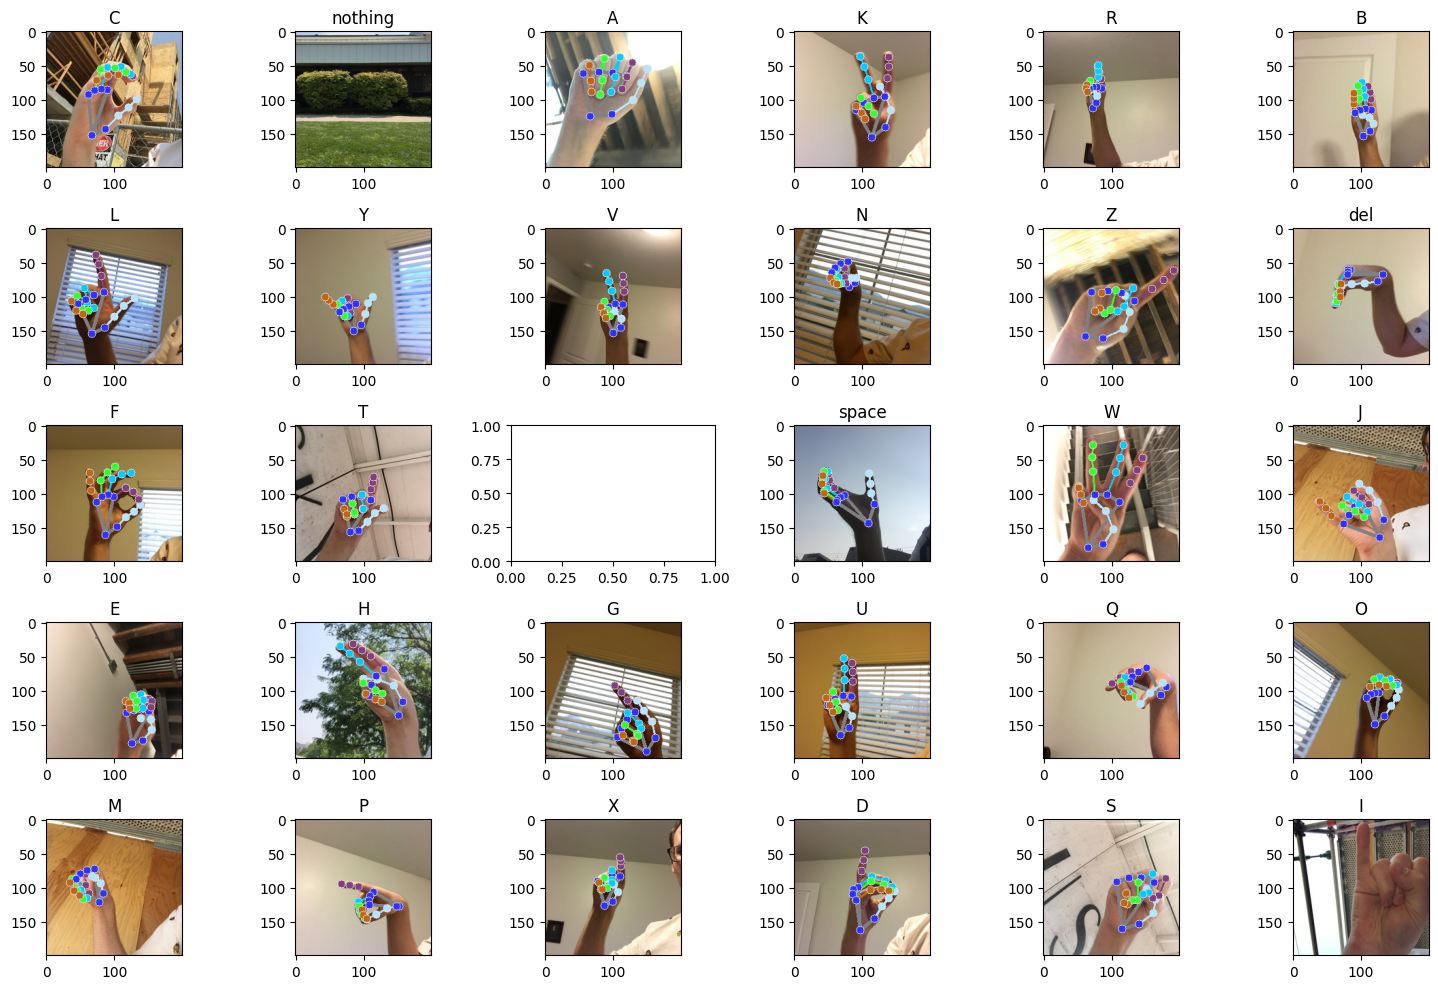

In [22]:
# Create subplots with 5 rows and 6 columns
num_rows = 5
num_cols = 6

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Get a list of subdirectories (A to Z)
subdirectories = [os.path.join(DATA_DIR, folder) for folder in os.listdir(DATA_DIR)]

for i, dir_ in enumerate(subdirectories):
    # Get the first image in each subdirectory
    img_files = [file for file in os.listdir(dir_) if file.endswith('.jpg')]
    if img_files:
        img_file = os.path.join(dir_, img_files[0])

        img = cv2.imread(img_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = hands.process(img_rgb)
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    img_rgb,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style()
                )

        # Calculate the row and column for the current subplot
        row = i // num_cols
        col = i % num_cols

        ax = axes[row, col]
        ax.imshow(img_rgb)
        ax.set_title(os.path.basename(dir_))

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

In [25]:
output_csv = 'dataset.csv'

In [27]:
# Open the CSV file for writing
file_name = open(output_csv, 'a')

# Loop through the folders and files in the image directory
for each_folder in os.listdir(DATA_DIR):
    if '._' in each_folder:
        pass
    else:
        for each_number in os.listdir(DATA_DIR + '/' + each_folder):
            if '._' in each_number:
                pass

            else:
                label = each_folder
                file_loc = DATA_DIR + '/' + each_folder + '/' + each_number

                # Read the static image
                hand_img = cv2.imread(file_loc)

                # Check if the image was loaded successfully
                if hand_img is None:
                    print(f"Error: Could not read image at {file_loc}. Skipping.")
                    continue  # Skip to the next image

                # Image processing
                # 1. Convert BGR to RGB
                img_rgb = cv2.cvtColor(hand_img, cv2.COLOR_BGR2RGB)

                # 2. Flip the img in Y-axis
                img_flip = cv2.flip(img_rgb, 1)

                # Accessing MediaPipe solutions
                mp_hands = mp.solutions.hands

                # Initialize Hands
                hands = mp_hands.Hands(static_image_mode=True,
                                       max_num_hands=1, min_detection_confidence=0.7)

                # Results
                output = hands.process(img_flip)

                hands.close()

                try:
                    data = output.multi_hand_landmarks[0]
                    print(data)

                    data = str(data)

                    data = data.strip().split('\n')

                    garbage = ['landmark {', '  visibility: 0.0', '  presence: 0.0', '}']

                    without_garbage = []

                    for i in data:
                        if i not in garbage:
                            without_garbage.append(i)

                    clean = []

                    for i in without_garbage:
                        i = i.strip()
                        clean.append(i[2:])

                    for i in range(0, len(clean)):
                        clean[i] = float(clean[i])

                    for id, i in enumerate(clean):
                        if id == 0:
                            print(i)

                        file_name.write(str(i))
                        file_name.write(',')

                    file_name.write(label)
                    file_name.write('\n')

                except:
                    file_name.write('0')
                    file_name.write(',')

                    file_name.write('None')
                    file_name.write('\n')

# Close the CSV file
file_name.close()
print('Data Created !!!')

Output streaming akan dipotong hingga 5000 baris terakhir.
landmark {
  x: 0.09154969453811646
  y: 0.44117334485054016
  z: -0.09861590713262558
}
landmark {
  x: 0.13955961167812347
  y: 0.552039623260498
  z: -0.1444074511528015
}
landmark {
  x: 0.1829974353313446
  y: 0.5791118144989014
  z: -0.16846723854541779
}
landmark {
  x: 0.26236996054649353
  y: 0.43881911039352417
  z: -0.03327706828713417
}
landmark {
  x: 0.19107499718666077
  y: 0.40618741512298584
  z: -0.12215499579906464
}
landmark {
  x: 0.22306852042675018
  y: 0.5375497341156006
  z: -0.13526123762130737
}
landmark {
  x: 0.25665566325187683
  y: 0.5638529062271118
  z: -0.12177843600511551
}
landmark {
  x: 0.357694149017334
  y: 0.44342851638793945
  z: -0.06749014556407928
}
landmark {
  x: 0.2964051365852356
  y: 0.47088339924812317
  z: -0.14282163977622986
}
landmark {
  x: 0.3098044693470001
  y: 0.5906532406806946
  z: -0.11901714652776718
}
landmark {
  x: 0.3296140134334564
  y: 0.5922638773918152
  z:

Untuk menampilkan 9 gambar dari batch yang diambil, bersama dengan prediksi kelas dari model dan class

In [28]:
#reading the csv files via pandas
df = pd.read_csv('dataset.csv')
df.columns = [i for i in range(df.shape[1])]
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.644943,0.761314,-4.820401e-07,0.541532,0.741931,-0.020710,0.448380,0.662519,-0.042174,0.361006,...,0.571031,0.377504,-0.084024,0.499573,0.336574,-0.099542,0.433219,0.328293,-0.106917,C
1,0.744218,0.790279,-3.130476e-07,0.655894,0.739985,-0.012070,0.603218,0.657455,-0.018746,0.562368,...,0.793242,0.477143,-0.038925,0.754857,0.430759,-0.057102,0.710458,0.408742,-0.066629,C
2,0.617299,0.643362,-3.360880e-07,0.552054,0.617656,-0.020519,0.498315,0.561677,-0.039117,0.465741,...,0.619582,0.395239,-0.066319,0.585984,0.365585,-0.078771,0.554047,0.356626,-0.084474,C
3,0.566661,0.814272,-6.293138e-07,0.446653,0.753852,-0.026172,0.353974,0.634685,-0.054809,0.273767,...,0.557798,0.379225,-0.131775,0.462776,0.333121,-0.150300,0.382660,0.318875,-0.157364,C
4,0.677537,0.840366,-4.838918e-07,0.591859,0.784261,-0.012019,0.529316,0.701358,-0.027920,0.479363,...,0.714750,0.506961,-0.069494,0.673939,0.465983,-0.080470,0.628242,0.450960,-0.084454,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
865,0.406839,0.661457,-4.494060e-07,0.347277,0.611845,-0.018275,0.324602,0.539690,-0.025490,0.343788,...,0.491394,0.430509,-0.006278,0.502185,0.391137,-0.006673,0.508778,0.352710,-0.000779,I
866,0.481837,0.615928,-3.414017e-07,0.439052,0.562559,-0.022283,0.422978,0.507321,-0.036445,0.449885,...,0.543842,0.424344,-0.016737,0.555034,0.393390,-0.017562,0.562813,0.369624,-0.014839,I
867,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df = df.rename(columns={63: 'Alphabet'})
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,Alphabet
0,0.644943,0.761314,-4.820401e-07,0.541532,0.741931,-0.020710,0.448380,0.662519,-0.042174,0.361006,...,0.571031,0.377504,-0.084024,0.499573,0.336574,-0.099542,0.433219,0.328293,-0.106917,C
1,0.744218,0.790279,-3.130476e-07,0.655894,0.739985,-0.012070,0.603218,0.657455,-0.018746,0.562368,...,0.793242,0.477143,-0.038925,0.754857,0.430759,-0.057102,0.710458,0.408742,-0.066629,C
2,0.617299,0.643362,-3.360880e-07,0.552054,0.617656,-0.020519,0.498315,0.561677,-0.039117,0.465741,...,0.619582,0.395239,-0.066319,0.585984,0.365585,-0.078771,0.554047,0.356626,-0.084474,C
3,0.566661,0.814272,-6.293138e-07,0.446653,0.753852,-0.026172,0.353974,0.634685,-0.054809,0.273767,...,0.557798,0.379225,-0.131775,0.462776,0.333121,-0.150300,0.382660,0.318875,-0.157364,C
4,0.677537,0.840366,-4.838918e-07,0.591859,0.784261,-0.012019,0.529316,0.701358,-0.027920,0.479363,...,0.714750,0.506961,-0.069494,0.673939,0.465983,-0.080470,0.628242,0.450960,-0.084454,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
865,0.406839,0.661457,-4.494060e-07,0.347277,0.611845,-0.018275,0.324602,0.539690,-0.025490,0.343788,...,0.491394,0.430509,-0.006278,0.502185,0.391137,-0.006673,0.508778,0.352710,-0.000779,I
866,0.481837,0.615928,-3.414017e-07,0.439052,0.562559,-0.022283,0.422978,0.507321,-0.036445,0.449885,...,0.543842,0.424344,-0.016737,0.555034,0.393390,-0.017562,0.562813,0.369624,-0.014839,I
867,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Menyimpan model

In [30]:
X = df.iloc[:, :-1]
print("Features shape =", X.shape)

Y = df.iloc[:, -1]
print("Labels shape =", Y.shape)

Features shape = (869, 63)
Labels shape = (869,)


In [43]:
print(df['Alphabet'].isnull().sum())

95


In [48]:
   df = df.dropna(subset=['Alphabet'])

   # Lakukan kembali pemisahan data latih dan uji dengan data yang sudah dibersihkan:
   X = df.iloc[:, :-1]
   Y = df.iloc[:, -1]

In [49]:
#splitting the training and testing data and training the model
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
svm = SVC(C=10, gamma=0.1, kernel='rbf')
svm.fit(x_train, y_train)

SVC(C=10, gamma=0.1)

In [50]:
#to check the acuracy of the trained svc model
y_pred = svm.predict(x_test)
acuracy = accuracy_score(y_pred, y_test)
print('accuracy_score =', acuracy,'%')

accuracy_score = 0.864516129032258 %


In [51]:
#for confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')

In [52]:
f1, recall, precision

(0.864516129032258, 0.864516129032258, 0.864516129032258)

<Axes: title={'center': 'Confusion Matrix - American Sign Language'}>

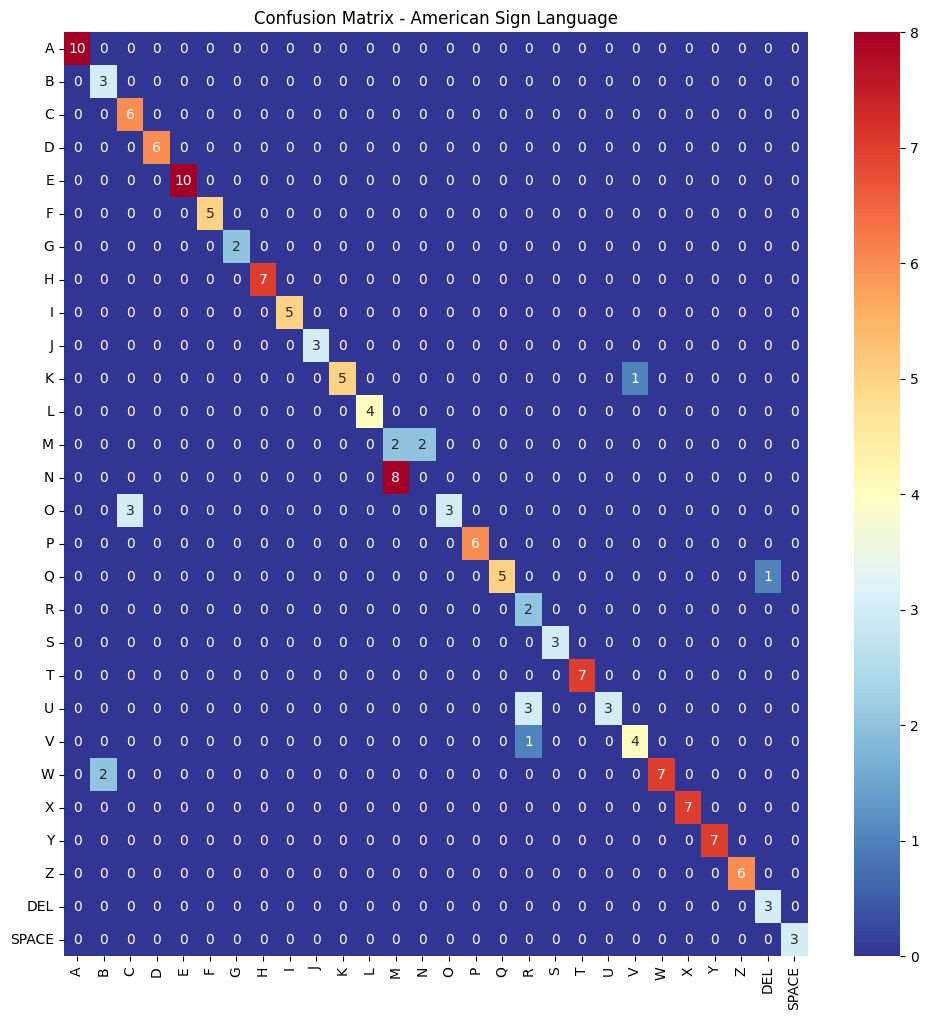

In [53]:
#plotting the confusion matrix
labels = sorted(list(set(df['Alphabet'])))
labels = [x.upper() for x in labels]

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title("Confusion Matrix - American Sign Language")

maping = sns.heatmap(cf_matrix,
                     annot=True,
                     linewidths=0,
                     cmap='RdYlBu_r',
                     xticklabels=labels,
                     yticklabels=labels, vmax=8,
                     fmt='g',
                     ax=ax
                    )
maping

In [55]:
# save model
with open('asl_model.pkl','wb') as f:
    pickle.dump(svm,f)